## Lagrangian Neural Network Implementation for modeling the Moab Simulator Data

### Introduction
This notebook implements the Lagrangian Neural Network (LNN) for the Moab device. The goal of this notebook is to explore feasibility of learning the lagrangian from states and actions collected using the Moab simulator data. The hypothesis under consideration are : 1) LNN captures physical behavior of the system from data, and we should observe the model to capture behavioral trends, 2) LNN uses limited data (100 episodes with 250 iteratiosn) a frequent limitation faced in many projects that require a physics based simulator.

The data for simulator is already collected using `ddm_data.py` and then rearranged for training and saved in `Xdata.npy` and `ydata.npy`. If you want to modify for other simulator example, replace the the csv file `moab_sim_100epiMinStates.csv` and add the configuration files in `\conf`. You can use `simulator\moab_simparam.yaml` and `data\moab_100epi.yaml` and change the file names in `config.yaml`. `\model` config is not required.

Sources:
  - Original paper on Lagrangian Neural Networks: [Cranmer 2020](https://arxiv.org/abs/2003.04630).
  - It uses the torchdyn library: https://github.com/DiffEqML/torchdyn. 
  - Pytorch and Pytorch Ligtning. Please see the `environment.yml`
  - Please read the `README.md` to run the notebook.



In [1]:
from torchdyn.models import *; from torchdyn.datasets import *
from torchdyn import *
from torch.autograd import grad
from base import BaseModel
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [2]:
X1 = np.load("Xdata5Kepi.npy")
y1 = np.load("ydata5Kepi.npy")
train_size = 200000
X=np.delete(X1,[4,5,6,7,12,13,14,15],1)
y=np.delete(y1,[4,5,6,7,12,13,14,15],1)

In [137]:
len(X)

232432

In [3]:
X[200000+2,:]

array([-0.21879837, -0.41887955, -0.08525487, -0.02054286,  9.94252562,
       10.        ,  0.12383117, -0.38045985, -0.08467024,  0.07977339,
       -0.07011178, -0.31635514, -0.02493212, -0.69719857, -0.21879837,
       -0.41887955])

In [4]:
y[200000+1,:]

array([-0.21879837, -0.41887955, -0.08525487, -0.02054286,  9.94252562,
       10.        ,  0.12383117, -0.38045985])

In [5]:
ydel =y[:,:]-X[:,:8]

In [6]:
model = BaseModel()

In [7]:
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# A=torch.Tensor(2**15, 2).uniform_(-1, 1).to(device) # random data test

In [8]:
Xs, ys = model.scalar(X,ydel)
Xst = torch.from_numpy(Xs.astype(np.float32))
yst = torch.from_numpy(ys.astype(np.float32))

In [9]:
Xs[:1,:]

array([[ 1.16761869,  0.28011931, -0.54641922, -1.43551681,  0.23526316,
        -1.17171252,  0.74221621, -1.66286205, -0.56532112, -1.48507995,
         0.74747407, -1.67736382,  1.16814404,  0.2782819 ,  1.16761869,
         0.28011931]])

In [10]:
y

array([[ -0.6393158 ,   0.85921935,  -0.06290321, ..., -10.        ,
         -0.75996018,   0.52603577],
       [  0.74628693,   0.1146468 ,  -0.04426516, ...,  -8.66985716,
         -0.98886771,   0.58612516],
       [  0.76672957,  -0.46637819,  -0.01701762, ...,  10.        ,
          0.38592679,  -0.8419251 ],
       ...,
       [  0.75621   ,  -0.57561259,  -0.12123344, ...,  10.        ,
         -0.65914182,   0.84302991],
       [  0.68665465,  -0.88636015,   0.07291725, ...,  10.        ,
         -0.68660807,   0.5006535 ],
       [  0.52052497,   0.36826622,   0.0399567 , ...,  -5.635987  ,
         -0.6474132 ,   0.52139844]])

### Inspect data

In [11]:
Xst[1,:]-Xst[0,:] # verify that a_t is not same as a_t recorded last as part of s_t i.e. column 6,7 != column 0,1

tensor([-2.2769,  1.2051, -0.4343,  3.0880,  0.9390,  0.0000, -2.2343,  2.6949,
        -0.4474,  3.1850, -2.2520,  2.7177, -2.2754,  1.2070, -2.2769,  1.2051])

In [12]:
yst[0,:] # not exactly same

tensor([-1.6110e+00,  8.5482e-01, -5.1434e-01,  3.6922e+00,  5.7881e-01,
        -1.9345e-03, -2.9274e+00,  3.4869e+00])

### Arrange split 

In [13]:
Xtrain = Xst[:train_size,:8] # For non-Moab cases: torch.cat((Xst[:20000,:4],yst[:20000,:2]-Xst[:20000,-2:], Xst[:20000,2:4]),1)
Xtest  = Xst[train_size:,:8]  # For non-Moab cases: torch.cat((Xst[20000:,:4],yst[20000:,:2]-Xst[20000:,-2:],Xst[20000:,2:4]),1)
ytrain = yst[:train_size,:]
ytest = yst[train_size:,:]

In [14]:
ytest[:1,:]

tensor([[ 0.4781, -0.6641,  0.0401, -0.3056, -1.3530,  0.3552,  0.1175, -0.0193]])

In [15]:
# Training dataset as part of dataloader for Pytorch Lightning
m, k, b = 1, 1, 1
# X = torch.Tensor(2**15, 4).uniform_(-1, 1).to(device)
train = data.TensorDataset(Xtrain, ytrain) #data.TensorDataset(X, Xdd)
trainloader = data.DataLoader(train, batch_size=128, shuffle=False)
test = data.TensorDataset(Xtest, ytest) #data.TensorDataset(X, Xdd)
testloader = data.DataLoader(test, batch_size=128, shuffle=False)

predict = data.TensorDataset(Xtest, ytest) #data.TensorDataset(X, Xdd)
predict_loader = data.DataLoader(predict, batch_size=128, shuffle=False)

### LNN modeling
Here, L and f are the lagrangian neural network and f is the forcing function. Action is added to fLNN to be used in the forcing function directly.

In [16]:
class fLNN(nn.Module):
    def __init__(self, L, f, u):
        super().__init__()
        self.L, self.f, self.u = L, f, u
    def forward(self, x):
        with torch.set_grad_enabled(True):
            self.n = n = x.shape[1]//2 # Split in position and velocity states, but remove actions     (6-2 = 4)/2       
            qqd = x.requires_grad_(True) # m x 4
            L = self._lagrangian(qqd).sum()
            J = grad(L, qqd, create_graph=True)[0] ; # m x 4
            DL_q, DL_qd = J[:,:n], J[:,n:] #J[:,:n], J[:,n:] mx2, mx2
            DDL_qd = []
            for i in range(n): # Replace range from n to full dimension. Previously used range(n):
                J_qd_i = DL_qd[:,i][:,None] # m x 1
                H_i = grad(J_qd_i.sum(), qqd, create_graph=True)[0][:,:,None] # m x 4
                DDL_qd.append(H_i) #m x 4 x 1 2 times
            DDL_qd = torch.cat(DDL_qd, 2) # m x 4 x 2
            DDL_qqd, DDL_qdqd = DDL_qd[:,:n,:], DDL_qd[:,n:,:]### m x 2 x 2, m x2 x 2
            T = torch.einsum('ijk, ij -> ik', DDL_qqd, qqd[:,n:]) # m x 2 x 2, m x 2 -> m x 2
            qdd = torch.einsum('ijk, ij -> ik', DDL_qdqd.inverse(), DL_q - T - self.f(self.u[:len(qqd),:]))#self.f(qqd))#[:,n:]) mx2x2,mx 2

        return torch.cat([qqd[:,self.n:], qdd], 1)

    def _lagrangian(self, qqd):
        return self.L(qqd)

### Learner is the function used for training, testing and predictions. 
Optimizer and learning rate can be changed here, or passed externally. Functions for test and predict are added to track outputs of prediction later

In [17]:
import pytorch_lightning as pl
# from pytorch_lightning import loggers as pl_loggers
# tb_logger = pl_loggers.TensorBoardLogger('logs/')

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model.defunc(0, x)

    def loss(self, y_hat, y):
        return ((y - y_hat)**2).mean()#((y - y_hat[:,1])**2).mean()

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model.defunc(0, x)
        loss = self.loss(y_hat, y)
#         print(loss.detach())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {'loss' : loss, 'y_pred' : y_hat, 'y_true' : y}#{'loss': loss}
    
    def test_step(self, batch, batch_idx):
        # Gets "x" and "y" tensors for current batch
        x, y = batch
        # OK to use output of forward for test (as per best practices PL)
        y_test = self.forward(x)
        # Calculate loss for the current batch
        loss = self.loss(y_test, y)
        self.log('y_test', y)

        return  {'test_loss' : loss }

    def predict(self, batch, batch_idx: int , dataloader_idx: int = None):
        x, y = batch
        y_hat = self.model.defunc(0, x)
        loss = self.loss(y_hat, y)
        return {'loss' : loss, 'y_pred' : y_hat, 'y_true' : y}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader
    
    
    def test_dataloader(self):
        return testloader

### Network Architecture for Lagrangian and forcing function
The lagrangian network L takes 4 inputs, two ball positions for x and y coordinates, and two ball velocities for xdot and ydot, representing state at time t (s_t). L has 4 outputs for the corresponding 4 states at time t+1 (s_t+1). Similarly, forcing function has 2 inputs for the two actions `roll` and `pitch`, outputs are two accelerations of the forces. Here, the forces are kept independent of states, as they are acting as external input. In some cases, force can be a function of states also. But, ball states usually do not affect the force, in case of Moab.

In [18]:
hdim = 128
L = nn.Sequential(
            nn.Linear(8, hdim),  ## Input is 4
            nn.Softplus(),
            nn.Linear(hdim, hdim),
            nn.Softplus(),
            nn.Linear(hdim, 8)).to(device) ## Output is 4

# Using forces independent of dynamics q and qd, all interaction is handled in fLLN.
f = nn.Sequential(
            nn.Linear(2, hdim), ## Input is 2 for 2 actions
            nn.Softplus(),
            nn.Linear(hdim, 4)).to(device) ## Output is 2 accelerations
netf = fLNN(L, f, Xst[:train_size,-2:])
modelf = NeuralDE(func=netf, solver='dopri5').to(device)

In [ ]:
# learn = Learner(modelf)
# trainer = pl.Trainer(max_epochs=10, log_every_n_steps=5) #, logger=tb_logger)#0)
# trainer.fit(learn)
# trainer.save_checkpoint("modelDelState.ckpt")

### Re-load from checkpoint - Trained Network

In [19]:
ckpt = torch.load("modelDelState.ckpt")
test = data.TensorDataset(Xtest[:250,:], ytest[:250,:]) #data.TensorDataset(X, Xdd)
predict_loaders = data.DataLoader(test, batch_size=250, shuffle=False)
netf = fLNN(L, f, Xst[train_size:train_size+250,:2])
modelf = NeuralDE(func=netf, solver='dopri5').to(device)
learn = Learner(modelf)
learn.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

### Test and Predict

In [20]:
netf = fLNN(L, f, Xst[train_size:train_size+250,-2:])
i = 250
test1 = data.TensorDataset(Xtest[:i,:], ytest[:i,:]) #data.TensorDataset(X, Xdd)
predict_loaders1 = data.DataLoader(test1, batch_size=i, shuffle=False)
learn = Learner(modelf)
trainer=pl.Trainer()
# trainer.test(learn) 
ypred=trainer.predict(learn, predict_loaders1)
# yout = np.concatenate((np.array(yst[train_size:train_size+i,:2]),ypred[0]['y_pred']),axis=1)
y_out = model.yscalar.inverse_transform(ypred[0]['y_pred'])

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

### Check visually how states are predicted w.r.t sim data (Red = Sim Data, Blue= Model prediction)

#### Roll Action (not part of model state) 

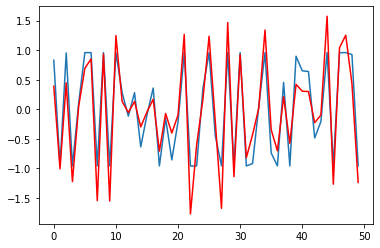

In [21]:
from matplotlib import pyplot as plt
plt.plot(y_out[:50,0])
plt.plot(ydel[200000:200050,0],'r')

#### Pitch Action (not part of model state)

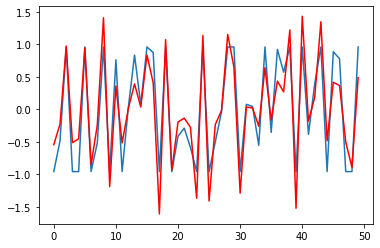

In [22]:
plt.plot(y_out[:50,1])
plt.plot(ydel[200000:200050,1],'r')

#### Ball X position over 150 time-steps

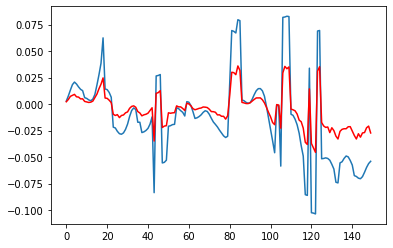

In [23]:
plt.plot(y_out[:150,2])
plt.plot(ydel[200000:200150,2],'r')

#### Ball Y position over 150 time-steps

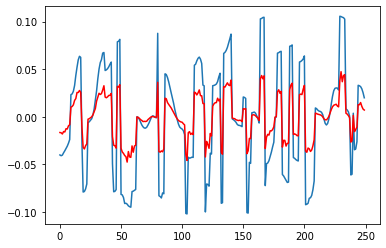

In [24]:
plt.plot(y_out[:,3])
plt.plot(ydel[200000:200250,3],'r')

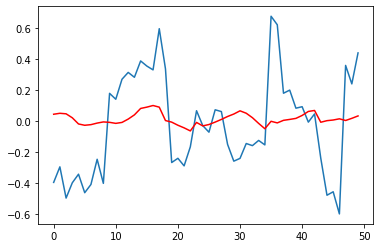

In [213]:
plt.plot(y_out[:50,6])
plt.plot(ydel[200000:200050,6],'r')

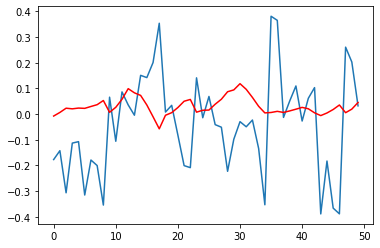

In [212]:
plt.plot(y_out[:50,7])
plt.plot(ydel[200000:200050,7],'r')

In [25]:
y.shape

(232432, 8)

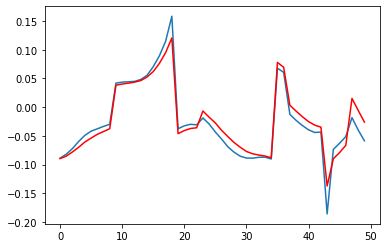

In [215]:
plt.plot(X[200000:200050,2]+y_out[0:50,2])
plt.plot(y[200000:200050,2],'r')

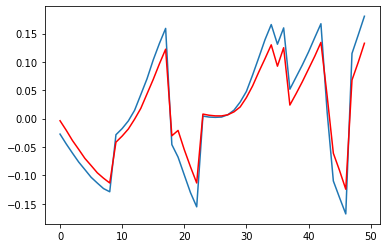

In [216]:
plt.plot(X[200000:200050,3]+y_out[0:50,3])
plt.plot(y[200000:200050,3],'r')

#### Ball X velocity over 150 time-steps

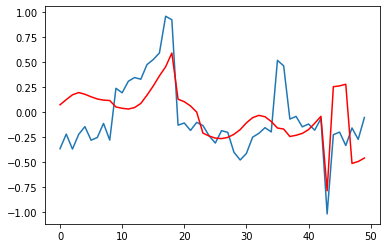

In [94]:
plt.plot(X[200000:200050,6]+y_out[:50,6])
plt.plot(y[200000:200050,6],'r')

#### Ball Y velocity over 150 time-steps

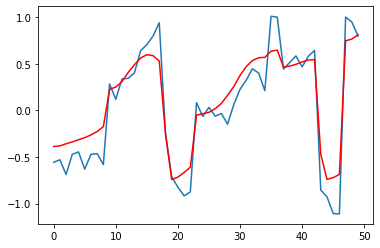

In [92]:
plt.plot(X[200000:200050,7]+y_out[:50,7])
plt.plot(y[200000:200050,7],'r')

In [28]:
LNN_singlestep=np.square(X[200000:200050,:8]+y_out[:50,:8]-y[200000:200050,:]).sum(axis=0)/50

In [29]:
LNN_singlestep

array([1.19827922e-01, 1.11657556e-01, 2.53213947e-04, 8.83419519e-04,
       2.15151674e+02, 2.27901652e+02, 9.93132325e-02, 4.52510455e-02])

In [219]:
# simdf = pd.read_csv('2021-03-24-16-25-21_SIMDATA5KepiDelState_logSingleStep.csv')
# xgdf  = pd.read_csv('2021-03-24-16-25-21_DDM5KepiDelState_logSingleStep.csv')
simdf = pd.read_csv('2021-03-25-10-48-34_SIMDATA_logXGB5KepiSingleStep.csv')
xgdf  = pd.read_csv('2021-03-25-10-48-34_DDM_logXGB5KepiSingleStep.csv')

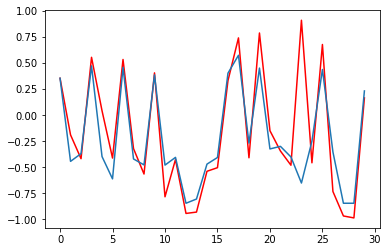

In [220]:
plt.plot(simdf['state_pitch'].iloc[:30],'r')
plt.plot(xgdf['state_pitch'].iloc[:30])

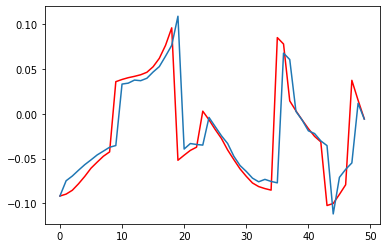

In [221]:
plt.plot(simdf['state_ball_x'].iloc[:50],'r')
plt.plot(xgdf['state_ball_x'].iloc[:50])

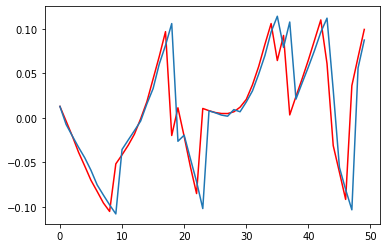

In [222]:
plt.plot(simdf['state_ball_y'].iloc[:50],'r')
plt.plot(xgdf['state_ball_y'].iloc[:50])

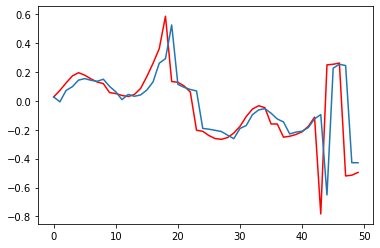

In [205]:
plt.plot(simdf['state_ball_vel_x'].iloc[:50],'r')
plt.plot(xgdf['state_ball_vel_x'].iloc[:50])

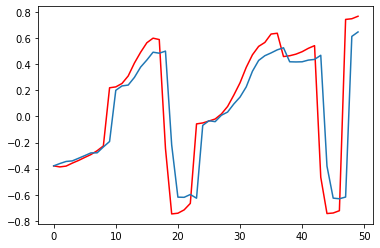

In [206]:
plt.plot(simdf['state_ball_vel_y'].iloc[:50],'r')
plt.plot(xgdf['state_ball_vel_y'].iloc[:50])

In [225]:
simdfTNNSS = pd.read_csv('2021-03-25-18-12-15_SIMDATA_log5KepiTNNSingleStep.csv')
tnndfSS  = pd.read_csv('2021-03-25-18-12-15_DDM_log5KepiTNNSingleStep.csv')

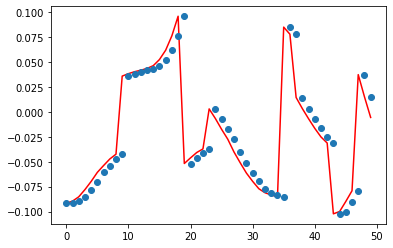

In [226]:
plt.plot(simdfTNNSS['state_ball_x'].iloc[:50],'r')
plt.plot(tnndfSS['state_ball_x'].iloc[:50],'o')

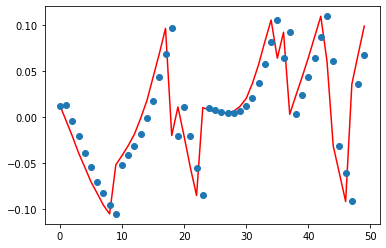

In [227]:
plt.plot(simdfTNNSS['state_ball_y'].iloc[:50],'r')
plt.plot(tnndfSS['state_ball_y'].iloc[:50],'o')

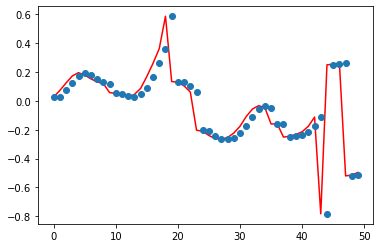

In [228]:
plt.plot(simdfTNNSS['state_ball_vel_x'].iloc[:50],'r')
plt.plot(tnndfSS['state_ball_vel_x'].iloc[:50],'o')

In [229]:
tNN_SingleStep=np.square(np.array(simdfTNNSS.iloc[:50,:8]-tnndfSS.iloc[:50,:8])).sum(axis=0)/50

In [230]:
tNN_SingleStep

array([7.40049711e-01, 6.21749850e-01, 1.69589791e-03, 1.60393684e-03,
       1.79218252e+02, 1.81069494e+02, 5.05815661e-02, 9.74289062e-02])

In [223]:
XG_SingleStep=np.square(np.array(simdf.iloc[:50,:8]-xgdf.iloc[:50,:8])).sum(axis=0)/50

In [224]:
XG_SingleStep

array([1.77764981e-01, 1.40723303e-01, 1.53947050e-03, 1.49766110e-03,
       4.78408259e+01, 5.62291002e+01, 4.57429852e-02, 8.96981358e-02])

In [38]:
LNN_singlestep

array([1.19827922e-01, 1.11657556e-01, 2.53213947e-04, 8.83419519e-04,
       2.15151674e+02, 2.27901652e+02, 9.93132325e-02, 4.52510455e-02])

### Error Propagation

### Prediction ddm-xgboost and sim

In [164]:
simdfe = pd.read_csv('2021-03-24-16-47-35_SIMDATA_log5KepiEpisode.csv')
xgdfe  = pd.read_csv('2021-03-24-16-47-35_DDM_log5KepiEpisode.csv')

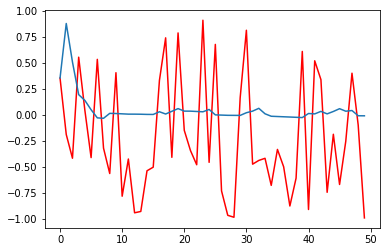

In [166]:
plt.plot(simdfe['state_pitch'].iloc[:50],'r')
plt.plot(xgdfe['state_pitch'].iloc[:50])

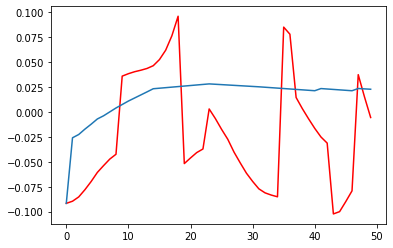

In [167]:
plt.plot(simdfe['state_ball_x'].iloc[:50],'r')
plt.plot(xgdfe['state_ball_x'].iloc[:50])

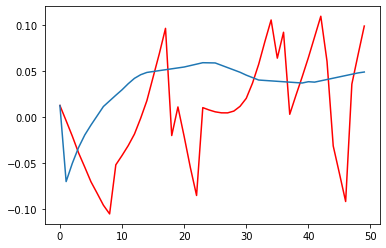

In [168]:
plt.plot(simdfe['state_ball_y'].iloc[:50],'r')
plt.plot(xgdfe['state_ball_y'].iloc[:50])
# plt.plot(0.2+simdf['iteration']*0.02)

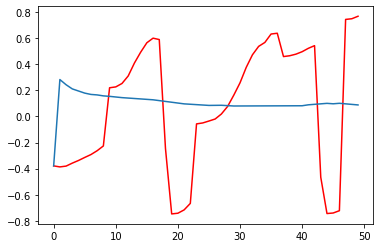

In [170]:
plt.plot(simdfe['state_ball_vel_y'].iloc[:50],'r')
plt.plot(xgdfe['state_ball_vel_y'].iloc[:50])

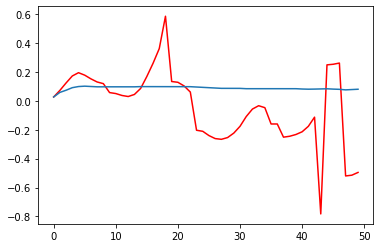

In [172]:
plt.plot(simdfe['state_ball_vel_x'].iloc[:50],'r')
plt.plot(xgdfe['state_ball_vel_x'].iloc[:50])

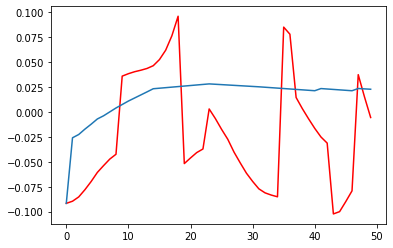

In [173]:
plt.plot(simdfe['state_ball_x'].iloc[:50],'r')
plt.plot(xgdfe['state_ball_x'].iloc[:50])

In [176]:
XG_episode=np.square(np.array(simdfe.iloc[:50,:8]-xgdfe.iloc[:50,:8])).sum(axis=0)/50

In [177]:
XG_episode

array([3.65484809e-01, 3.84468405e-01, 4.13132540e-03, 3.78220675e-03,
       6.77320767e+01, 7.14965149e+01, 7.59839722e-02, 2.40481680e-01])

In [51]:
LNN_singlestep

array([1.19827922e-01, 1.11657556e-01, 2.53213947e-04, 8.83419519e-04,
       2.15151674e+02, 2.27901652e+02, 9.93132325e-02, 4.52510455e-02])

#### First pass -- similar to episode start in brain/RL training

In [52]:
Xt=simdf.iloc[:,:8].to_numpy()

### Predict DDM Torch NN and sim

In [231]:
simdfe2 = pd.read_csv('2021-03-25-18-28-54_SIMDATA_log5KepiTNNEpisode.csv')
tnndfe  = pd.read_csv('2021-03-25-18-28-54_DDM_log5KepiTNNEpisode.csv')

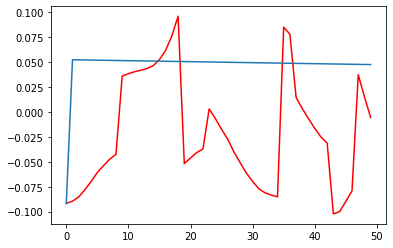

In [236]:
plt.plot(simdfe2['state_ball_x'].iloc[:50],'r')
plt.plot(tnndfe['state_ball_x'].iloc[:50])

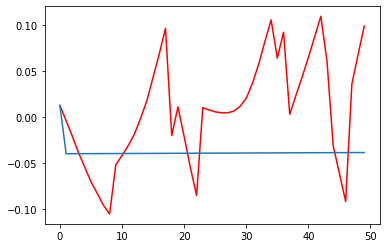

In [232]:
plt.plot(simdfe2['state_ball_y'].iloc[:50],'r')
plt.plot(tnndfe['state_ball_y'].iloc[:50])

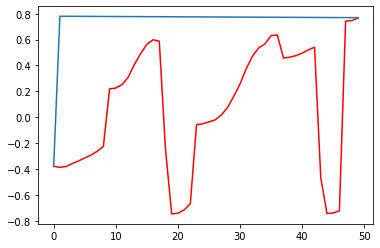

In [233]:
plt.plot(simdfe2['state_ball_vel_y'].iloc[:50],'r')
plt.plot(tnndfe['state_ball_vel_y'].iloc[:50])

In [234]:
NN_episode=np.square(np.array(simdfe2.iloc[:50,:8]-tnndfe.iloc[:50,:8])).sum(axis=0)/50

In [235]:
NN_episode

array([9.61084558e-01, 5.39887403e-01, 7.78966702e-03, 5.34696666e-03,
       6.77061047e+01, 6.85297354e+01, 6.12244224e-02, 6.93045058e-01])

In [54]:
# Use checkpointed learned network for 1st prediction
def episode_start(i=0):
    test1 = data.TensorDataset(Xtest[i:i+1,:], ytest[i:i+1,:]) #data.TensorDataset(X, Xdd)
    predict_loaders1 = data.DataLoader(test1, batch_size=1, shuffle=False)
    netf = fLNN(L, f, Xst[200000+i:200000+i+1,:2]) # Send Action from forcing function
    modelf = NeuralDE(func=netf, solver='dopri5').to(device)
    learn1 = Learner(modelf)
    learn1.load_state_dict(ckpt['state_dict'])

    trainer1 = pl.Trainer()
    ypred1=trainer1.predict(learn1, predict_loaders1)
# yout1 = np.concatenate((np.array(yst[200000:200000+i,:2]),ypred1[0]['y_pred']),axis=1)
    y_out1 = X[200000+i,:8]+model.yscalar.inverse_transform(ypred1[0]['y_pred'])
    return y_out1, ypred1

In [55]:
np.array(yst[200000:200000+i,:2]).shape

(250, 2)

In [56]:
y_out1,ypred1 = episode_start(1)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

In [57]:
ypred1[0]['y_pred']

array([[-1.1740087 , -0.593526  ,  0.14099433, -0.7563304 ,  1.0466479 ,
        -0.14733087, -0.75412804, -0.36163908]], dtype=float32)

In [58]:
ypred1[0]['y_true'][0][2]

0.07992606

In [59]:
y_out1[0][2]

-0.0819317114040494

In [60]:
y[200000+1,:]

array([-0.21879837, -0.41887955, -0.08525487, -0.02054286,  9.94252562,
       10.        ,  0.12383117, -0.38045985])

In [ ]:
X[:10,9]

#### All following passes: similar to episode step in brain/RL training

In [64]:
o_list = [ypred1[0]['y_pred']]
y_list = [ypred1[0]['y_true']]
yout_list=[y_out1]#.reshape(1,6)]
yinp = model.yscalar.transform(y_out1)
for i in range(1,50):
    testI = data.TensorDataset(torch.from_numpy(yinp.astype(np.float32)), ytest[i:i+1,:]) #data.TensorDataset(X, Xdd)
    predict_loadersI = data.DataLoader(testI, batch_size=1, shuffle=False)
    netf2 = fLNN(L, f, Xst[200000+i:200000+i+1,:2])
    modelf = NeuralDE(func=netf2, solver='dopri5').to(device)
    learnI = Learner(modelf)
#     learnI.load_state_dict(ckpt['state_dict'])
    trainerI = pl.Trainer()
    ypred1=trainerI.predict(learnI, predict_loadersI)
#     yout1 = np.concatenate((np.array(yst[200000+i,:2]),ypred1[0]['y_pred'][0]),axis=0)
    y_out1 = y_out1+model.yscalar.inverse_transform(ypred1[0]['y_pred'])
    yinp = model.yscalar.transform(y_out1)
    o_list.append(ypred1[0]['y_pred'])
    y_list.append(ypred1[0]['y_true'])
    yout_list.append(y_out1)#.reshape(1,6))
    if (abs(y_out1[0][2])>0.1125) or (abs(y_out1[0][3])>0.1125): # Radius of plate is 0.1125m so ball falls off.
        y_out1,y_pred1 = episode_start(i)
        yinp = model.yscalar.transform(y_out1)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

In [98]:
yinp

array([[ 0.04321091, -0.04095399, -1.07603751,  3.33600793,  1.02015585,
        -0.85793816, -0.1403622 ,  2.02381957]])

In [99]:
ypred1[0]['y_pred']

array([[ 1.5225341, -1.0979927, -0.7029607,  2.408488 ,  2.282842 ,
        -1.3379228,  0.5500257,  0.915764 ]], dtype=float32)

In [100]:
ol=np.concatenate(o_list,axis=0)
yl = np.concatenate(y_list,axis=0)
yo = np.concatenate(yout_list,axis=0)

#### Actual and predicted deltas between moab states at time t+1 and states at time t

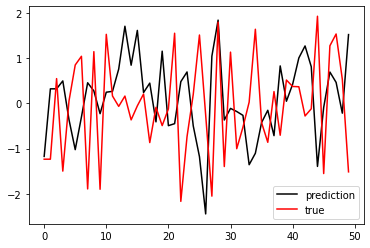

In [101]:
plt.plot(ol[:50,0],'k',label='prediction')
plt.plot(yl[:50,0],'r', label='true')
plt.legend(loc="lower right")

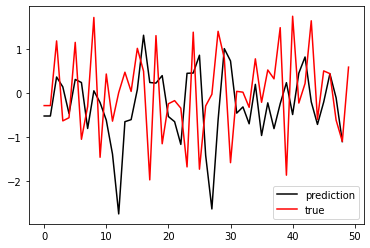

In [102]:
plt.plot(ol[1:50,1],'k',label='prediction')
plt.plot(yl[:50,1],'r',label='true')
plt.legend(loc="lower right")

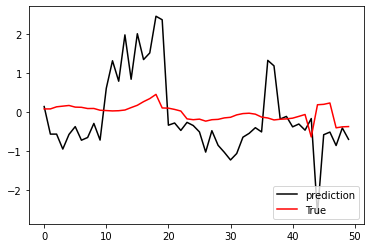

In [103]:
plt.plot(ol[:50,2],'k',label='prediction')
plt.plot(yl[:50,2],'r',label='True')
plt.legend(loc="lower right")

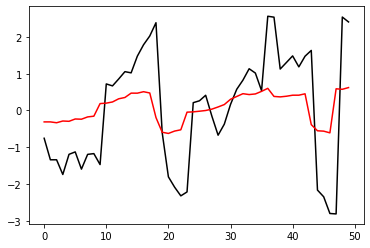

In [104]:
plt.plot(ol[:50,3],'k',label='prediction')
plt.plot(yl[:50,3],'r',label='True')
# plt.plot(ytest[1:150,3])

### Actual and predicted moab states at time t+1
### Prediction using previous inputs of model-entire trajectory prediction

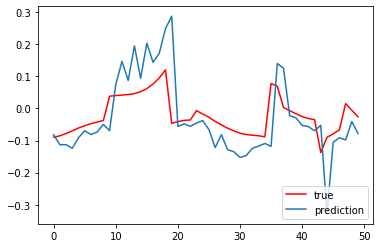

In [105]:
plt.plot(y[train_size:train_size+50,2],'r',label='true')
plt.plot(yo[:50,2],label='prediction')
plt.legend(loc="lower right")

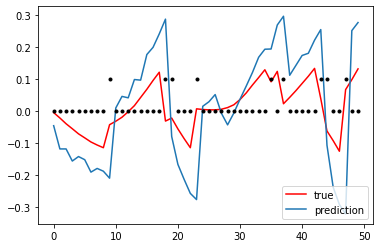

In [251]:
plt.plot(y[train_size:train_size+50,3],'r',label='true')
plt.plot(yo[:50,3],label='prediction')
plt.legend(loc="lower right")
plt.plot((X1[train_size:train_size+50,7]==0).astype(np.float32)*0.1,'.k',label='episode')

In [107]:
plt.plot(xgdf['state_ball_x'].iloc[])
plt.plot(simdf['state_ball_x'])

SyntaxError: invalid syntax (<ipython-input-107-7cd4f772d0cf>, line 1)

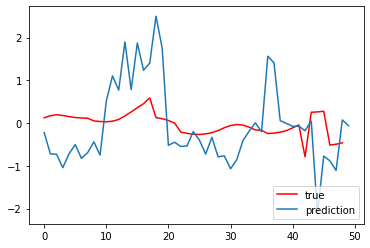

In [114]:
plt.plot(y[train_size+1:train_size+50,6],'r',label='true')
plt.plot(yo[:50,6],label='prediction')
plt.legend(loc="lower right")

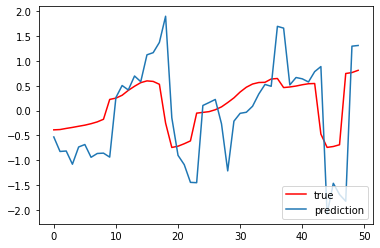

In [115]:
plt.plot(y[train_size:train_size+50,7],'r',label='true')
plt.plot(yo[:50,7],label='prediction')
plt.legend(loc="lower right")

In [110]:
yo.shape

(50, 8)

In [135]:
LNN_episode=np.square(y[train_size:train_size+50,:]-yo[:50,:]).sum(axis=0)/50

In [136]:
LNN_episode

array([2.59522681e+00, 2.19646376e+00, 7.86960024e-03, 1.64144331e-02,
       6.52897835e+02, 7.25574586e+02, 8.45564630e-01, 6.24332808e-01])

In [ ]:
XG_episode

In [ ]:
LNN_singlestep

### XGBOOST DDM vs data

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
# df=pd.read_csv('2021-03-17-18-52-21_SIMDATA_COMPAREFIXEDPOLICY200Kmodel_log.csv')
dfDDM = pd.read_csv('2021-03-20-22-46-46_SIMDATA5KepiDiffState_log.csv')
dfSIM = pd.read_csv('2021-03-20-22-46-46_DDM5KepiDiffState_log.csv')

In [ ]:
plt.plot(dfDDM['state_ball_x'][:50],'k')
plt.plot(dfSIM['state_ball_x'][:50],'r')

In [ ]:
plt.plot(dfDDM['state_ball_y'][:50],'k')
plt.plot(dfSIM['state_ball_y'][:50],'r')

In [ ]:
plt.plot(dfDDM['state_ball_vel_x'][:40],'k')
plt.plot(dfSIM['state_ball_vel_x'][:40],'r')

In [ ]:
plt.plot(dfDDM['state_ball_vel_y'][:30],'k')
plt.plot(dfSIM['state_ball_vel_y'][:30],'r')
plt.plot(dfSIM['iteration'][:30])

In [ ]:
Total_Error_lnn=y_out[:,[2,3,6,7]]-y[200000:200250,[2,3,6,7]]

In [ ]:
y[200000:200250,[2,3,6,7]].shape

In [ ]:
Total_Error_lnn.shape

In [ ]:
Total_Error_xgb=np.array([ dfDDM['state_ball_x']-dfSIM['state_ball_x'],dfDDM['state_ball_y']-dfSIM['state_ball_y'], dfDDM['state_ball_vel_x']-dfSIM['state_ball_vel_x'],dfDDM['state_ball_vel_y']-dfSIM['state_ball_vel_y']])

In [ ]:
Total_Error_xgb.shape

In [ ]:
SSE_xgb = np.square(Total_Error_xgb).sum(axis=1)

In [ ]:
SSE_xgb

In [ ]:
SSE_lnn = np.square(Total_Error_lnn).sum(axis=0)

In [ ]:
SSE_lnn